# GARCH(1,1) Model Analysis
Based on Lecture 3: The GARCH Model by Zheng Tian

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
%matplotlib inline

## Step 1: Download Financial Data

In [15]:
# Download S&P 500 and Gold
sp500 = yf.download('^GSPC', start='2010-01-01', end='2024-12-31')['Close']
gold = yf.download('GC=F', start='2010-01-01', end='2024-12-31')['Close']

# Compute daily percentage returns
sp500_returns = sp500.pct_change().dropna()
gold_returns = gold.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Step 2: Define Function to Fit GARCH(1,1)

In [16]:
def fit_garch_model(returns, title):
    # Scale returns for better convergence
    am = arch_model(returns * 100, vol='Garch', p=1, q=1, dist='Normal')
    res = am.fit(disp='off', options={'ftol': 1e-10})
    print(f"\n=== {title} ===")
    print(res.summary())
    
    # Standardized residuals
    std_resid = res.std_resid
    
    # Plot standardized residuals
    plt.figure(figsize=(12, 4))
    plt.plot(std_resid)
    plt.title(f'Standardized Residuals - {title}')
    plt.grid(True)
    plt.show()
    
    # ACF of residuals
    plot_acf(std_resid, lags=20)
    plt.title(f'ACF of Standardized Residuals - {title}')
    plt.show()
    
    # Ljung-Box test
    lb_test = acorr_ljungbox(std_resid, lags=10, return_df=True)
    print("\nLjung-Box Test for Serial Correlation:")
    print(lb_test.head())
    
    return res

## Step 3: Fit Models


=== S&P 500 (Model A) ===
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4837.43
Distribution:                  Normal   AIC:                           9682.86
Method:            Maximum Likelihood   BIC:                           9707.80
                                        No. Observations:                 3772
Date:                Mon, Jun 16 2025   Df Residuals:                     3771
Time:                        22:53:26   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0822  1.224e-02     

/home/son/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
/home/son/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
/home/son/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by 

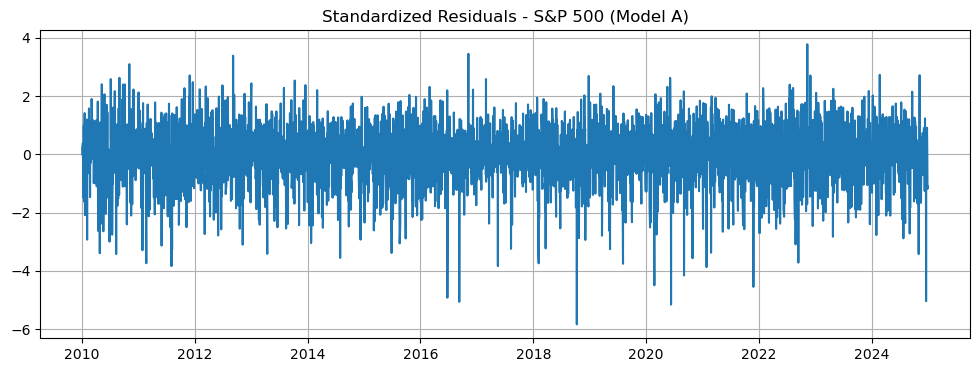

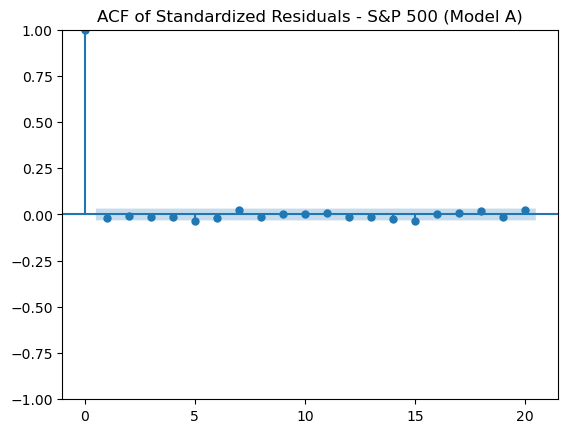


Ljung-Box Test for Serial Correlation:
    lb_stat  lb_pvalue
1  1.769162   0.183486
2  1.961731   0.374986
3  2.732011   0.434815
4  3.448124   0.485810
5  8.741855   0.119814

=== Gold (Model B) ===
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   GC=F   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5184.58
Distribution:                  Normal   AIC:                           10377.2
Method:            Maximum Likelihood   BIC:                           10402.1
                                        No. Observations:                 3769
Date:                Mon, Jun 16 2025   Df Residuals:                     3768
Time:                        22:53:26   Df Model:                            1
                                  Mean Model                                 
         

/home/son/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
/home/son/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
/home/son/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by 

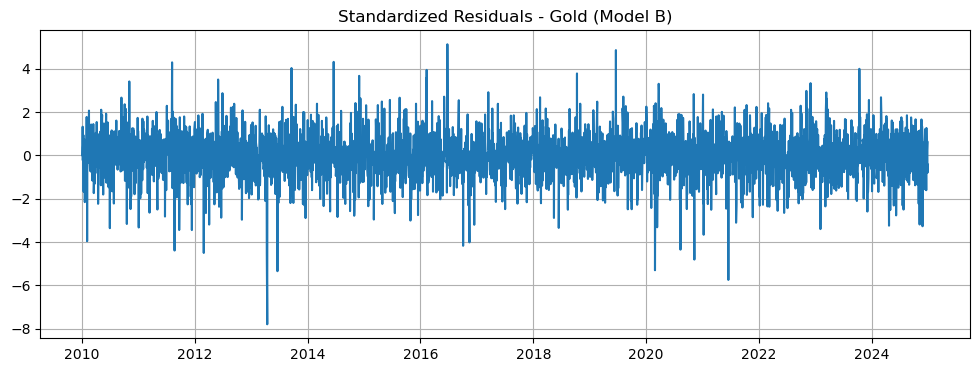

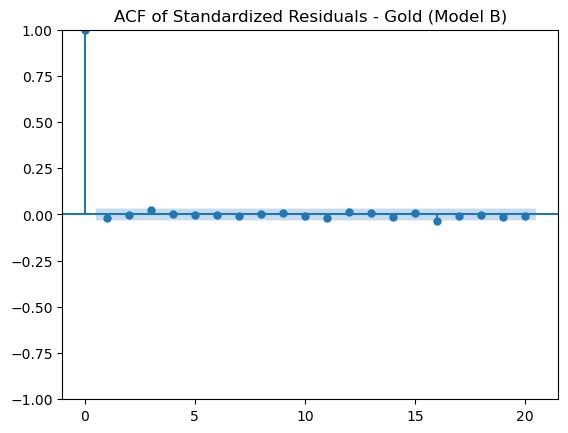


Ljung-Box Test for Serial Correlation:
    lb_stat  lb_pvalue
1  1.633304   0.201247
2  1.633518   0.441861
3  4.336001   0.227393
4  4.336415   0.362387
5  4.347486   0.500545


In [17]:
res_sp500 = fit_garch_model(sp500_returns, 'S&P 500 (Model A)')
res_gold = fit_garch_model(gold_returns, 'Gold (Model B)')

## Step 4: Extract and Compare Parameters

In [18]:
def summarize_garch_results(res, title):
    params = res.params
    alpha1 = params['alpha[1]']
    beta1 = params['beta[1]']
    persistence = alpha1 + beta1
    long_run_var = params['omega'] / (1 - persistence)
    
    print(f"\n=== Summary - {title} ===")
    print(f"alpha1:      {alpha1:.4f}")
    print(f"beta1:       {beta1:.4f}")
    print(f"Persistence: {persistence:.4f}")
    print(f"Long-run variance: {long_run_var:.4f}")
    print(f"AIC:         {res.aic:.2f}")
    print(f"BIC:         {res.bic:.2f}")

summarize_garch_results(res_sp500, 'S&P 500 (Model A)')
summarize_garch_results(res_gold, 'Gold (Model B)')


=== Summary - S&P 500 (Model A) ===
alpha1:      0.1650
beta1:       0.8031
Persistence: 0.9680
Long-run variance: 1.1605
AIC:         9682.86
BIC:         9707.80

=== Summary - Gold (Model B) ===
alpha1:      0.0401
beta1:       0.9438
Persistence: 0.9839
Long-run variance: 1.0093
AIC:         10377.17
BIC:         10402.11


## Step 5: Forecast Volatility

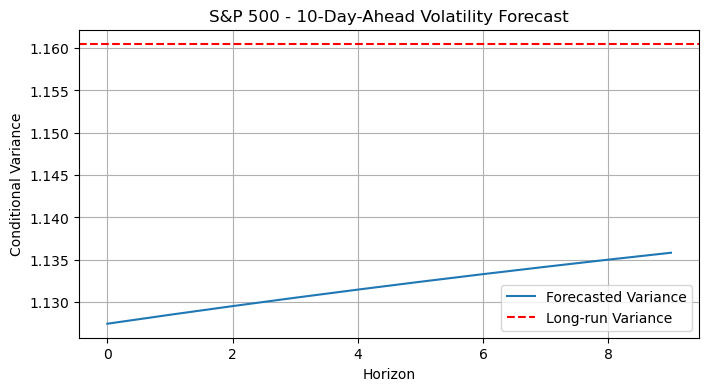

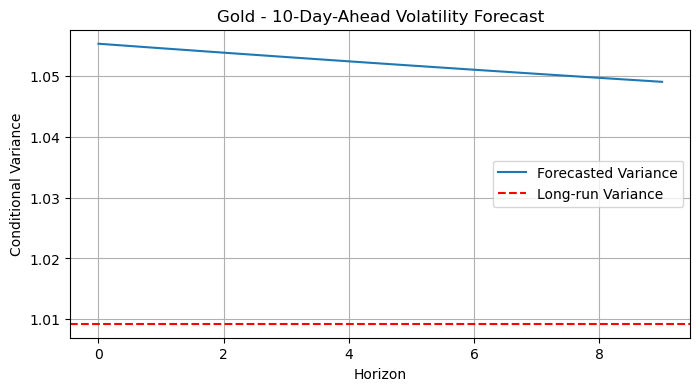

In [19]:
def forecast_volatility(model_result, horizon=10, title=""):
    forecasts = model_result.forecast(horizon=horizon, reindex=False)
    cond_var = forecasts.variance.iloc[-1].values
    
    plt.figure(figsize=(8, 4))
    plt.plot(cond_var, label='Forecasted Variance')
    plt.axhline(y=model_result.params['omega'] / (1 - model_result.params['alpha[1]'] - model_result.params['beta[1]']),
                color='r', linestyle='--', label='Long-run Variance')
    plt.title(f"{title} - {horizon}-Day-Ahead Volatility Forecast")
    plt.xlabel("Horizon")
    plt.ylabel("Conditional Variance")
    plt.legend()
    plt.grid(True)
    plt.show()

forecast_volatility(res_sp500, title='S&P 500')
forecast_volatility(res_gold, title='Gold')